In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import pandas as pd
import shutil

from PIL import Image

In [2]:
# Mounting Drive to read data on Google Colab
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/_MVA/Medical Image Analysis

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/_MVA/Medical Image Analysis


# Exploratory Data Analysis

## Data cleaning

In [3]:
data_dir = r'Dataset_BUSI_with_GT/not_normal'

files = glob.glob(data_dir + '/*/*.png')

scan_paths = [f for f in files if ('mask' not in f)]
mask_paths = [f for f in files if ('mask' in f)]

print(f'There are {len(scan_paths)} scans and {len(mask_paths)} masks.')

There are 0 scans and 0 masks.


When there is more than one tumor in an image, there are different masks for that same image. Thus we will sum these masks to get a single mask by image.

In [4]:
img_names = [os.path.basename(path).split('_')[0] for path in mask_paths]

In [5]:
# Create dictionary : img_name (str): mask is unique or not (bool)
is_unique_dict = {name: True for name in img_names}
for i, name in enumerate(img_names):
    for name2 in img_names[i+1:]:
        if (name == name2):
            is_unique_dict[name] = False
            break

In [6]:
for (img_name, is_unique) in is_unique_dict.items():
    # Get all masks corresponding to the iage
    paths = glob.glob(data_dir + f'/*/{img_name}_mask*.png')
    masks = []
    for path in paths:
        mask = np.array(Image.open(path))
        # Handle RGB images
        if mask.ndim != 2:
            mask = mask[:, :, 0] / 255
        masks.append(mask)
    # Sum all masks into one
    masks = np.array(masks)
    final_mask = masks.sum(axis=0)
    # Save to a new folder
    plt.imsave(rf'Dataset_BUSI_with_GT/cleaned_data/{img_name}_mask.png', final_mask, cmap=cm.gray)    

In [7]:
# Copy scans to the cleaned_data folder
for path in scan_paths:
    shutil.copyfile(path, r'Dataset_BUSI_with_GT/cleaned_data/' + os.path.basename(path))

# Creation of the Database

In [134]:
data_dir = r'Dataset_BUSI_with_GT/cleaned_data'

files = glob.glob(data_dir + '/*.png')

scan_paths = [f for f in files if ('mask' not in f)]
mask_paths = [f for f in files if ('mask' in f)]

print(f'There are {len(scan_paths)} scans and {len(mask_paths)} masks.')

There are 647 scans and 647 masks.


In [139]:
database = pd.DataFrame({'image': scan_paths, 'mask': [path.split('.')[0] + '_mask.png' for path in scan_paths]})

for idx, mask_path in enumerate(database['mask']):
    mask = np.array(Image.open(mask_path))
    # For image with 4 channels
    if mask.ndim != 2:
        mask = mask[:,:,0] / 255
    database.loc[idx, 'n_tumor'] = mask.mean()

#database.to_csv(r'Dataset_BUSI_with_GT/cleaned_data/data.csv', index=False)

database.head()

,image,mask,n_tumor
0,Dataset_BUSI_with_GT/cleaned_data/benign (158)...,Dataset_BUSI_with_GT/cleaned_data/benign (158)...,0.141447
1,Dataset_BUSI_with_GT/cleaned_data/benign (121)...,Dataset_BUSI_with_GT/cleaned_data/benign (121)...,0.044980
2,Dataset_BUSI_with_GT/cleaned_data/benign (18).png,Dataset_BUSI_with_GT/cleaned_data/benign (18)_...,0.198419
3,Dataset_BUSI_with_GT/cleaned_data/benign (166)...,Dataset_BUSI_with_GT/cleaned_data/benign (166)...,0.011075
4,Dataset_BUSI_with_GT/cleaned_data/benign (128)...,Dataset_BUSI_with_GT/cleaned_data/benign (128)...,0.014921


## Study of tumor size for unbalanced segmentation

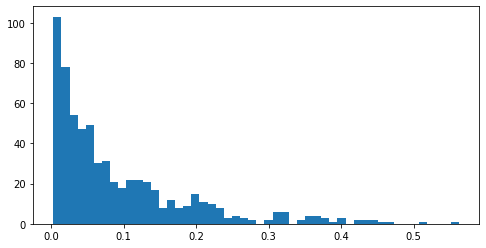

In [140]:
plt.figure(figsize=(8,4))
plt.hist(database['n_tumor'], bins=50)
plt.show()

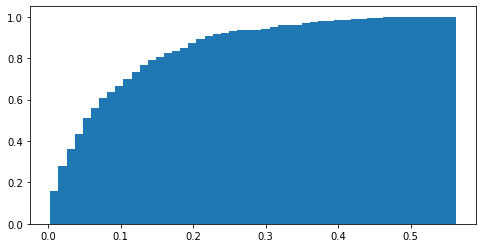

In [141]:
plt.figure(figsize=(8,4))
plt.hist(database['n_tumor'], density=True, cumulative=True, bins=50)
plt.show()

In [12]:
thresh = 0.05
n_keep = len(database.loc[database['n_tumor'] < thresh])
n_tot = len(database)
print('By keeping image with less than {:.1f}% tumor, we keep {:.2f}% of the database, which corresponds to {} images.'.format(
            100*thresh, n_keep / n_tot, n_keep))

By keeping image with less than 5.0% tumor, we keep 0.45% of the database, which corresponds to 293 images.


# Training 

In [13]:
import cv2

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import Resize
from tqdm import tqdm

In [48]:
BATCH_SIZE = 16
LR = 0.01
EPOCHS = 10

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [195]:
class MyDataset(data.Dataset):
    def __init__(self, df):
        self.database = df
    
    def __len__(self):
        return len(self.database)
    
    def __getitem__(self, idx):
        row = self.database.iloc[idx]
        img = np.array(Image.open(row['image'])) / 255
        mask = np.array(Image.open(row['mask'])) / 255

        img = cv2.resize(np.float32(img), (256,256))
        mask = cv2.resize(np.float32(mask), (256,256))

        img = torch.tensor(img)
        img = torch.moveaxis(img, 2, 0)

        mask = torch.tensor((mask > 0.5)).float()[:,:,0]
        return img, mask

In [196]:
#database = pd.read_csv('Dataset_BUSI_with_GT/cleaned_data/data.csv')
dataset_df = database.loc[database['n_tumor'] < 0.05]

database.head()

,image,mask,n_tumor
0,Dataset_BUSI_with_GT/cleaned_data/benign (158)...,Dataset_BUSI_with_GT/cleaned_data/benign (158)...,0.141447
1,Dataset_BUSI_with_GT/cleaned_data/benign (121)...,Dataset_BUSI_with_GT/cleaned_data/benign (121)...,0.044980
2,Dataset_BUSI_with_GT/cleaned_data/benign (18).png,Dataset_BUSI_with_GT/cleaned_data/benign (18)_...,0.198419
3,Dataset_BUSI_with_GT/cleaned_data/benign (166)...,Dataset_BUSI_with_GT/cleaned_data/benign (166)...,0.011075
4,Dataset_BUSI_with_GT/cleaned_data/benign (128)...,Dataset_BUSI_with_GT/cleaned_data/benign (128)...,0.014921


In [197]:
train_idx = np.random.choice(dataset_df.index, size=int(0.8*len(dataset_df)))
val_idx = list(set(dataset_df.index) - set(train_idx))

train_ds = MyDataset(dataset_df.loc[train_idx])
val_ds = MyDataset(dataset_df.loc[val_idx])

train_loader = data.DataLoader(train_ds, batch_size = BATCH_SIZE)
val_loader = data.DataLoader(val_ds, batch_size = BATCH_SIZE)

In [237]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False)

# Change first layer to have 1 entry channel
#model.encoder1.enc1conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model = nn.Sequential(model, nn.Sigmoid())
model.to(device)


optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = torch.nn.BCELoss(reduction='mean')


def train(epoch):
    model.train()
    for (img, mask) in tqdm(train_loader, total=len(train_loader)):
        img, mask = img.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(img).squeeze(dim=1)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        
    print(' Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.data.item()))

def validation():
    model.eval()
    validation_loss = 0
    acc = 0
    with torch.no_grad():
      for img, mask in val_loader:
          img, mask = img.to(device), mask.to(device)
          output = model(img).squeeze(dim=1)

          # sum up batch loss
          validation_loss += criterion(output, mask).data.item()

          pred = (output > 0.8)
          acc += (pred == (mask > 0.5)).float().mean()

    acc /= len(val_loader)
    validation_loss /= len(val_loader.dataset)
  
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {:.3f}'.format(
        validation_loss, acc))
    
    return acc

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [238]:
save_dir = 'CE_loss'

for epoch in range(1, EPOCHS + 1):
    best_val_acc = 0
    train(epoch)
    val_acc = validation()
    model_file = save_dir + 'best_model.pth'
    
    if val_acc > best_val_acc:
      best_val_acc = val_acc
      torch.save(model.state_dict(), model_file)

  0%|          | 0/15 [00:00<?, ?it/s]


RuntimeError: ignored

tensor(0.0221, device='cuda:0')


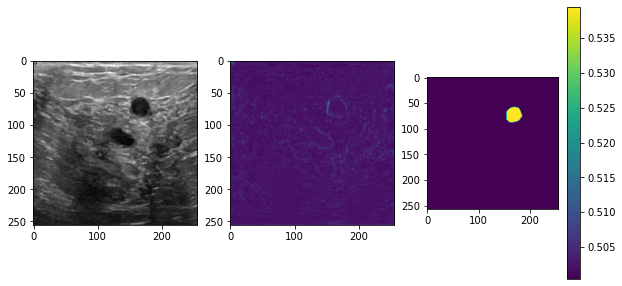

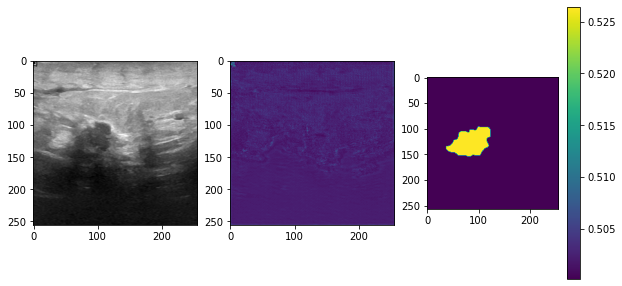

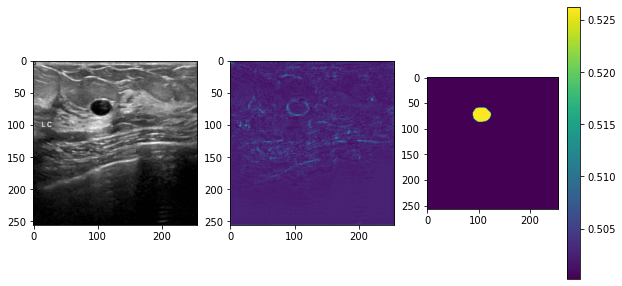

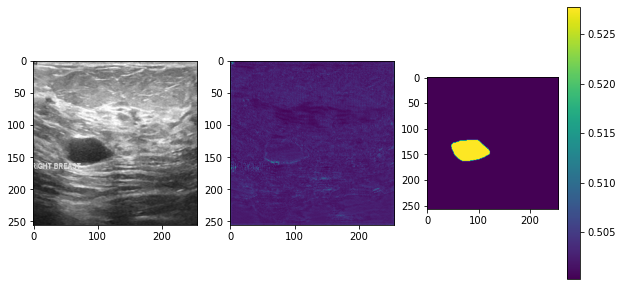

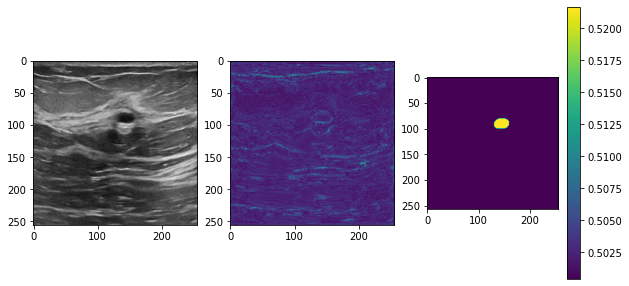

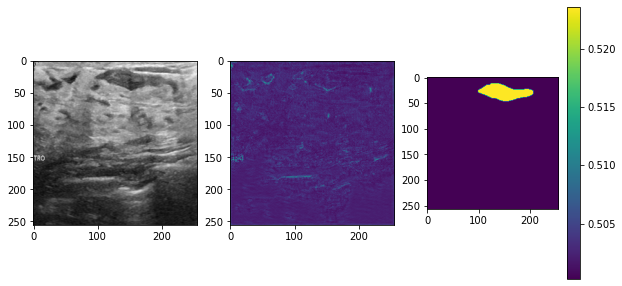

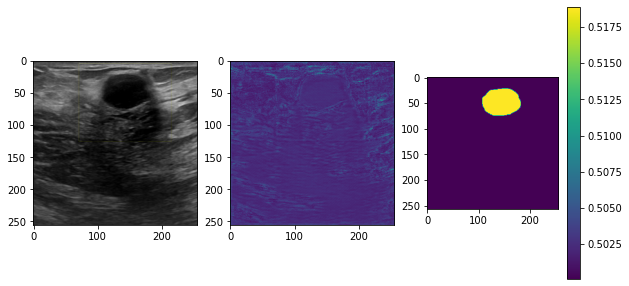

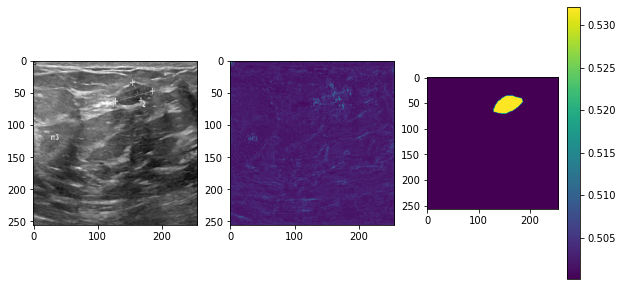

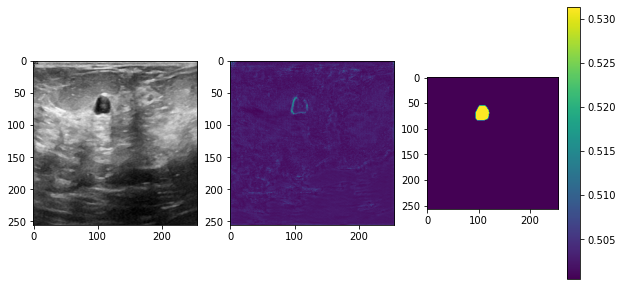

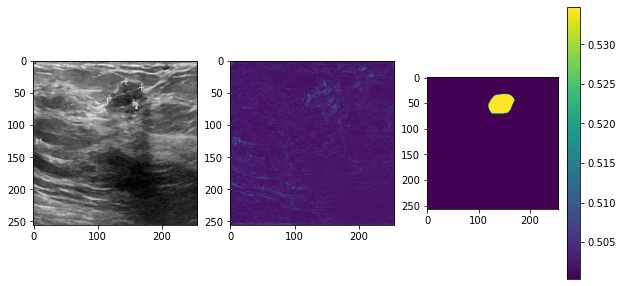

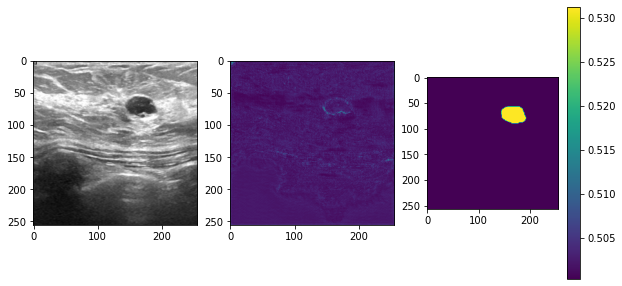

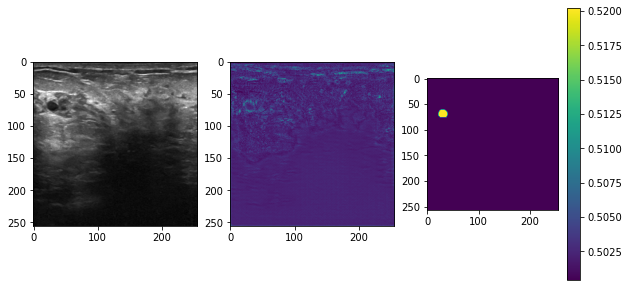

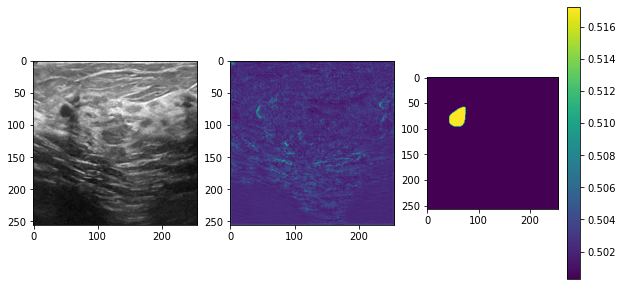

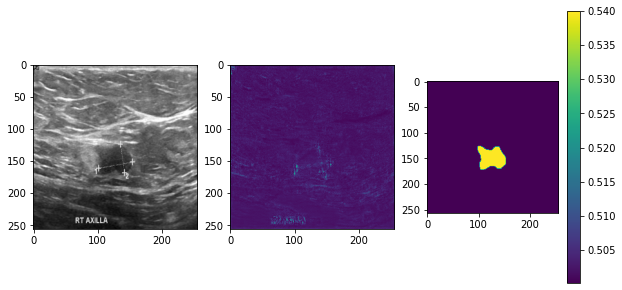

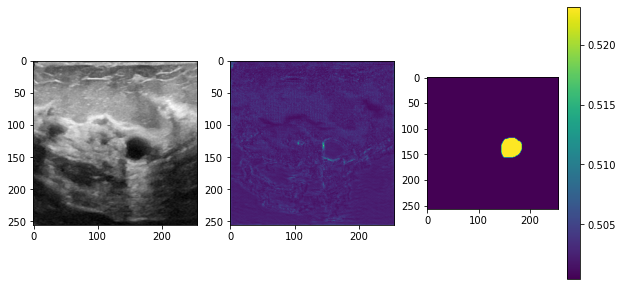

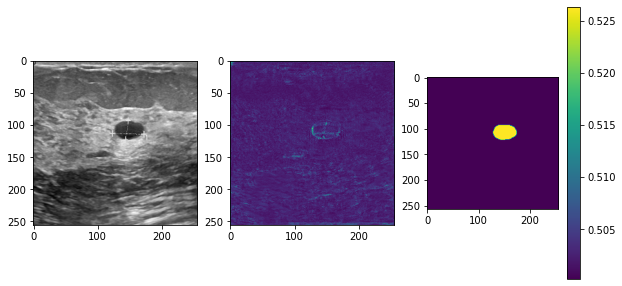

In [232]:
for img, mask in val_loader:
  img = img.to(device)
  pred = model(img).squeeze(dim=1)
  print(((pred>0.5) == (mask > 0.5).to(device)).float().mean())
  for k in range(BATCH_SIZE):
    fig, axes = plt.subplots(1, 3, figsize=(10,5))
    axes[0].imshow(np.moveaxis(np.array(img[k].cpu()), 0, 2))
    axes[1].imshow(pred[k].cpu().detach())
    plt.colorbar(axes[1].imshow(pred[k].cpu().detach()))
    axes[2].imshow(mask[k]>0.5)
    plt.show()
  
  break
